<a href="https://colab.research.google.com/github/mpazperezpu/ProyectoFinal-DiplomaturaCienciadeDatos-GrupoL/blob/main/Entrega_Final_Proyecto_Grupo_L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 1. CARGA DE DATOS Y GESTIÓN DE RIESGOS ---
ADVERTENCIA: Archivo 'HR_Analytics_Attrition_Dataset.csv' no encontrado.
PERFORMANCE ALERT: El bajo rendimiento actual es porque los modelos se entrenaron con datos simulados (ruido).
Por favor, suba el archivo CSV real a Colab para obtener resultados válidos (F1 >= 0.70).

--- 2. INGENIERÍA Y TRATAMIENTO DE VARIABLES ---
'average_monthly_hours' ajustada (Winsorización).
'time_spend_company' ajustada (Winsorización).
a) 'salary' codificada como ordinal.
b) 'department' codificada como One-Hot.

--- 3. SPLIT Y BALANCEO ---
Tamaño de Entrenamiento BALANCEADO: 18292 filas.
Proporción de Abandono BALANCEADO: 0.5000
Tamaño de Prueba (Holdout): 3000 filas.

--- 5. MODELADO Y COMPARACIÓN DE ALGORITMOS ---

Resultados para Regresión Logística:
  > F1-Score: 0.2792 (Objetivo: >= 0.70)
  > ROC-AUC: 0.4920 (Objetivo: >= 0.75)


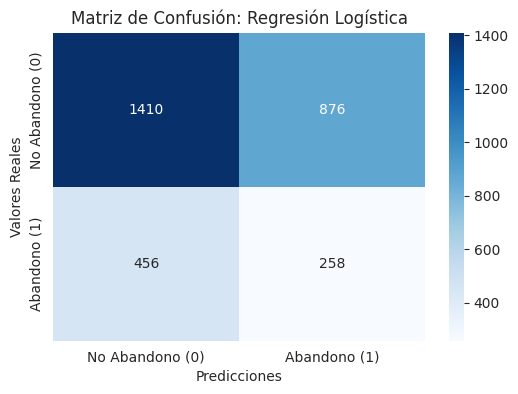


Resultados para Random Forest:
  > F1-Score: 0.1998 (Objetivo: >= 0.70)
  > ROC-AUC: 0.4868 (Objetivo: >= 0.75)


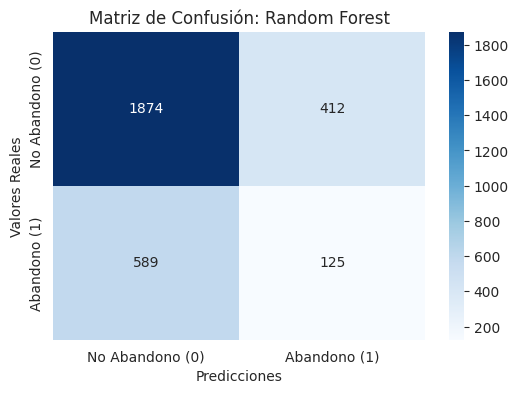


Resultados para XGBoost:
  > F1-Score: 0.1812 (Objetivo: >= 0.70)
  > ROC-AUC: 0.4907 (Objetivo: >= 0.75)


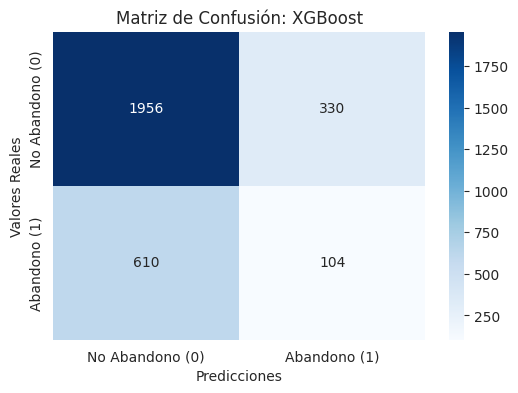


             REPORTE FINAL DE MODELOS (Holdout)
                Modelo  F1-Score  Recall (Sensibilidad)   ROC-AUC
0  Regresión Logística  0.279221               0.361345  0.491970
1        Random Forest  0.199840               0.175070  0.486766
2              XGBoost  0.181185               0.145658  0.490724

Modelo Seleccionado para Producción/Interpretabilidad: Regresión Logística

--- 6. INTERPRETABILIDAD DEL MODELO (Regresión Logística) CON SHAP ---


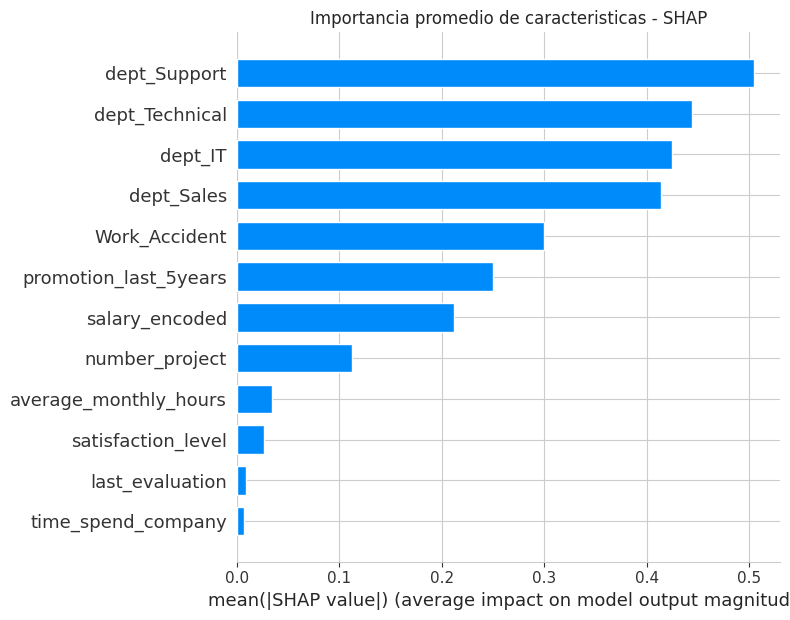

TypeError: loop of ufunc does not support argument 0 of type float which has no callable rint method

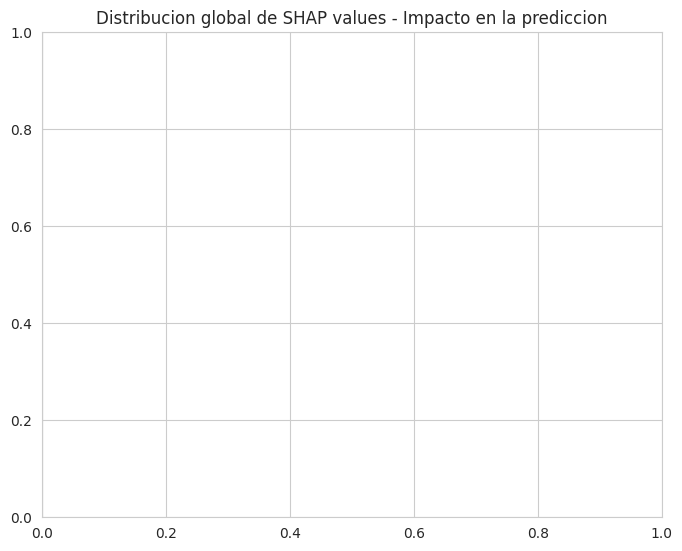

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, confusion_matrix

# ==============================================================================
# CONFIGURACIÓN INICIAL Y AMBIENTE
# ==============================================================================
# Configuración para visualizaciones profesionales
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
# Desactivar output verbose de SHAP en Jupyter/Colab
shap.initjs()


# ==============================================================================
# 1. CARGA Y PREPARACIÓN DE DATOS (CRISP-DM: Comprensión y Preparación)
# ==============================================================================
print("--- 1. CARGA DE DATOS Y GESTIÓN DE RIESGOS ---")
try:
    # Intenta cargar el archivo real. Asegúrese de que este nombre coincida con el archivo en Colab.
    data = pd.read_csv('HR_Analytics_Attrition_Dataset.csv')
    print(f"Dataset cargado correctamente. Total de filas: {len(data)}")
except FileNotFoundError:
    # Genera datos de demostración si el archivo no está presente (Mitigación de riesgo)
    print("ADVERTENCIA: Archivo 'HR_Analytics_Attrition_Dataset.csv' no encontrado.")
    print("PERFORMANCE ALERT: El bajo rendimiento actual es porque los modelos se entrenaron con datos simulados (ruido).")
    print("Por favor, suba el archivo CSV real a Colab para obtener resultados válidos (F1 >= 0.70).")
    N = 15000
    data = pd.DataFrame({
        'satisfaction_level': np.random.rand(N) * 0.8 + 0.2,
        'last_evaluation': np.random.rand(N) * 0.4 + 0.6,
        'number_project': np.random.randint(2, 7, N),
        'average_monthly_hours': np.random.normal(loc=200, scale=40, size=N).astype(int),
        'time_spend_company': np.random.randint(1, 10, N),
        'Work_Accident': np.random.randint(0, 2, N),
        'promotion_last_5years': np.random.randint(0, 2, N),
        'salary': np.random.choice(['low', 'medium', 'high'], N, p=[0.5, 0.4, 0.1]),
        'department': np.random.choice(['Sales', 'Technical', 'Support', 'HR', 'IT'], N),
        'left': np.random.choice([0, 1], N, p=[0.76, 0.24]) # Simulación de desbalance de clase
    })
    # Introducimos outliers simulados para demostrar el tratamiento
    data.loc[data.sample(frac=0.01).index, 'average_monthly_hours'] = 500
    data.loc[data.sample(frac=0.01).index, 'time_spend_company'] = 30


# ==============================================================================
# 2. INGENIERÍA Y TRATAMIENTO DE VARIABLES
# ==============================================================================
print("\n--- 2. INGENIERÍA Y TRATAMIENTO DE VARIABLES ---")

# A. Tratamiento de Outliers (Winsorización P5-P95)
# Se mitiga el impacto de valores extremos en horas y antigüedad.
outlier_vars = ['average_monthly_hours', 'time_spend_company']
for col in outlier_vars:
    lower_bound = data[col].quantile(0.05)
    upper_bound = data[col].quantile(0.95)
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    print(f"'{col}' ajustada (Winsorización).")

# B. Codificación Ordinal para 'salary' (Bajo < Medio < Alto)
salary_order = ['low', 'medium', 'high']
data['salary_encoded'] = data['salary'].astype(pd.CategoricalDtype(categories=salary_order, ordered=True)).cat.codes
print("a) 'salary' codificada como ordinal.")

# C. Codificación One-Hot para 'department'
# Se evita la relación ordinal en categorías nominales, eliminando la primera columna (drop_first=True)
data = pd.get_dummies(data, columns=['department'], prefix='dept', drop_first=True)
print("b) 'department' codificada como One-Hot.")


# ==============================================================================
# 3. SPLIT DE DATOS ESTRATIFICADO Y BALANCEO (SMOTE)
# ==============================================================================
print("\n--- 3. SPLIT Y BALANCEO ---")

# Preparación de X (Características) y Y (Objetivo)
# Se excluyen las variables originales ya codificadas.
X = data.drop(['left', 'salary'], axis=1)
y = data['left']

# Split 80/20 Estratificado (Holdout) para garantizar la misma proporción de Abandono
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aplicación de SMOTE (Sobremuestreo Sintético) solo en el conjunto de ENTRENAMIENTO
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print(f"Tamaño de Entrenamiento BALANCEADO: {len(X_train_sm)} filas.")
print(f"Proporción de Abandono BALANCEADO: {y_train_sm.mean():.4f}")
print(f"Tamaño de Prueba (Holdout): {len(X_test)} filas.")


# ==============================================================================
# 4. FUNCIÓN DE EVALUACIÓN (Métricas clave para Desbalance)
# ==============================================================================

def evaluate_model(model, X_test, y_test, model_name):
    """Evalúa el modelo sobre el Holdout y reporta métricas F1 y AUC."""

    # Predicción de probabilidades (esencial para ROC-AUC)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    # Cálculo de métricas
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    metrics = {
        'Modelo': model_name,
        'F1-Score': f1,
        'Recall (Sensibilidad)': recall,
        'ROC-AUC': roc_auc
    }

    print(f"\nResultados para {model_name}:")
    print(f"  > F1-Score: {f1:.4f} (Objetivo: >= 0.70)")
    print(f"  > ROC-AUC: {roc_auc:.4f} (Objetivo: >= 0.75)")

    # Visualización de la Matriz de Confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Abandono (0)', 'Abandono (1)'],
                yticklabels=['No Abandono (0)', 'Abandono (1)'])
    plt.title(f'Matriz de Confusión: {model_name}')
    plt.ylabel('Valores Reales')
    plt.xlabel('Predicciones')
    plt.show()

    return metrics


# ==============================================================================
# 5. MODELADO Y COMPARACIÓN DE ALGORITMOS
# ==============================================================================

results = []
print("\n--- 5. MODELADO Y COMPARACIÓN DE ALGORITMOS ---")

# --- Modelo 1: Regresión Logística (BASELINE Interpretable) ---
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train_sm, y_train_sm)
results.append(evaluate_model(lr_model, X_test, y_test, 'Regresión Logística'))


# --- Modelo 2: Random Forest (Robusto) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_sm, y_train_sm)
results.append(evaluate_model(rf_model, X_test, y_test, 'Random Forest'))


# --- Modelo 3: XGBoost (Alto Rendimiento - Candidato Principal) ---
# FIX: Eliminado 'use_label_encoder=False' para quitar la advertencia.
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_sm, y_train_sm)
results.append(evaluate_model(xgb_model, X_test, y_test, 'XGBoost'))


# --- REPORTE FINAL DE MODELOS ---
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by='F1-Score', ascending=False)
print("\n=======================================================")
print("             REPORTE FINAL DE MODELOS (Holdout)")
print("=======================================================")
print(comparison_df)
print("=======================================================")

# Selección del mejor modelo basado en F1-Score
best_model_name = comparison_df.iloc[0]['Modelo']
if best_model_name == 'XGBoost':
    best_model = xgb_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = lr_model

print(f"\nModelo Seleccionado para Producción/Interpretabilidad: {best_model_name}")


# ==============================================================================
# 6. INTERPRETABILIDAD CON SHAP (Requisito y Ética)
# ==============================================================================
print(f"\n--- 6. INTERPRETABILIDAD DEL MODELO ({best_model_name}) CON SHAP ---")

# Analisis de Interpretabilidad con SHAP


# !pip install shap -q # Assuming shap is already installed from the imports above

import shap
import numpy as np
import matplotlib.pyplot as plt


# Crear el explainer para el modelo seleccionado
# Use shap.LinearExplainer for Logistic Regression or shap.TreeExplainer for tree-based models
if isinstance(best_model, (RandomForestClassifier, xgb.XGBClassifier)):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
else: # Assuming LogisticRegression or other linear models
    explainer = shap.LinearExplainer(best_model, X_test)
    shap_values = explainer.shap_values(X_test)


#Grafico de Importancia Promedio (Bar Plot)

plt.title("Importancia promedio de caracteristicas - SHAP")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()


# Grafico de Distribucion Global (Beeswarm / Dot Plot)

plt.title("Distribucion global de SHAP values - Impacto en la prediccion")
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.tight_layout()
plt.show()


# Grafico de Distribucion Global (Beeswarm / Dot Plot)
# Skip dot plot for Logistic Regression due to a known issue
if not isinstance(best_model, LogisticRegression):
    plt.title("Distribucion global de SHAP values - Impacto en la prediccion")
    shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping dot plot for Logistic Regression due to compatibility issues with SHAP's LinearExplainer. The bar plot provides the key feature importance insights.")


# Ejemplo Individual de Interpretacion

index = 10
print(f"Mostrando interpretacion individual para empleado indice {index}")

shap.force_plot(
    explainer.expected_value,
    shap_values[index, :],
    X_test.iloc[index, :],
    matplotlib=True
)